## Max Wagner
### Data 620 - Homework Week 6

This week's assignment looks at an old data set called the Davis Club. Networkx provide a sample of code to get the set working. I used that sample along with a few minor alterations.

In [1]:
%matplotlib inline
import networkx as nx
import networkx.algorithms.bipartite as bipartite
import matplotlib.pyplot as plt
from networkx.algorithms.components.connected import connected_components
import numpy
from scipy.spatial import distance
from scipy.cluster import hierarchy
from collections import defaultdict

In [2]:
G = nx.davis_southern_women_graph()
women, clubs = nx.bipartite.sets(G)

**The women can be see below.**

In [3]:
women

{'Brenda Rogers',
 'Charlotte McDowd',
 'Dorothy Murchison',
 'Eleanor Nye',
 'Evelyn Jefferson',
 'Flora Price',
 'Frances Anderson',
 'Helen Lloyd',
 'Katherina Rogers',
 'Laura Mandeville',
 'Myra Liddel',
 'Nora Fayette',
 'Olivia Carleton',
 'Pearl Oglethorpe',
 'Ruth DeSand',
 'Sylvia Avondale',
 'Theresa Anderson',
 'Verne Sanderson'}

**And now the clubs.**

In [4]:
clubs

{'E1',
 'E10',
 'E11',
 'E12',
 'E13',
 'E14',
 'E2',
 'E3',
 'E4',
 'E5',
 'E6',
 'E7',
 'E8',
 'E9'}

**Let's plot the entire network.**

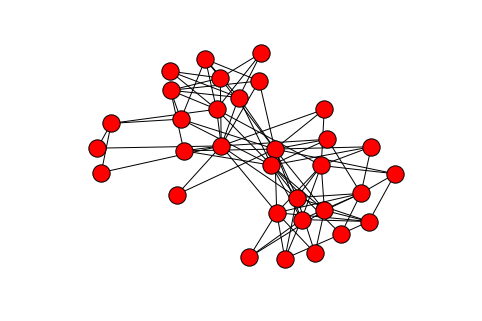

In [5]:
nx.draw(G)

**That doesn't tell us very much. Let's color code the women and clubs.**

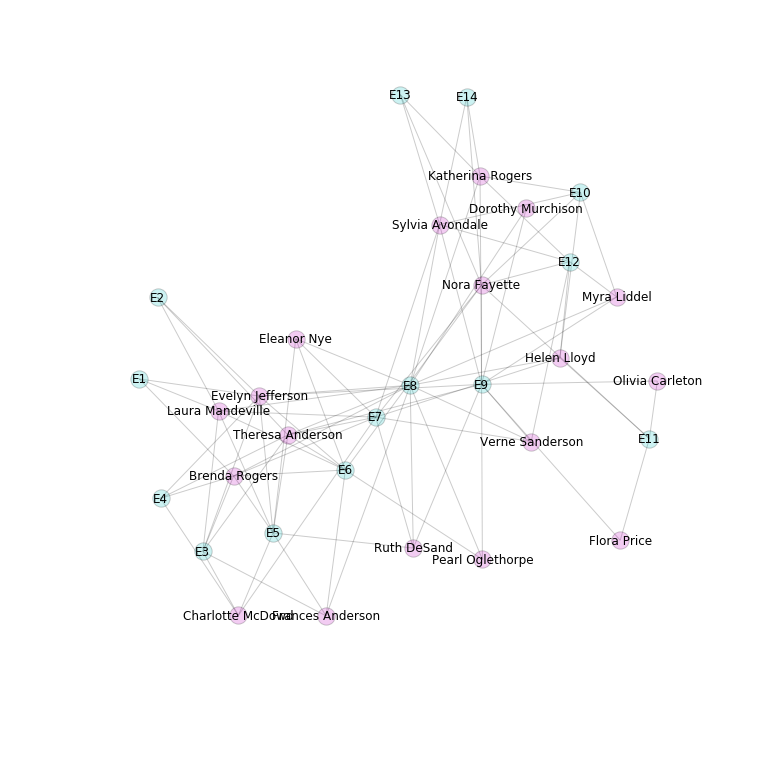

In [6]:
plt.figure(figsize = (13, 13))
plt.axis('off')
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=women, node_color='m', alpha = .2)
nx.draw_networkx_nodes(G, pos, nodelist=clubs, node_color='c', alpha = .2)
nx.draw_networkx_edges(G, pos, alpha = .2)
nx.draw_networkx_labels(G, pos);

**This is a start to getting closer to understanding the network. Nodes for women are magenta while nodes for clubs are cyan. The next step is to look at some of the values in the data. The information below is a sorted output of how many connections each woman and club has.**

In [7]:
sorted(zip(G.degree().values(), G.degree().keys()), reverse = True)

[(14, 'E8'),
 (12, 'E9'),
 (10, 'E7'),
 (8, 'Theresa Anderson'),
 (8, 'Nora Fayette'),
 (8, 'Evelyn Jefferson'),
 (8, 'E6'),
 (8, 'E5'),
 (7, 'Sylvia Avondale'),
 (7, 'Laura Mandeville'),
 (7, 'Brenda Rogers'),
 (6, 'Katherina Rogers'),
 (6, 'E3'),
 (6, 'E12'),
 (5, 'Helen Lloyd'),
 (5, 'E10'),
 (4, 'Verne Sanderson'),
 (4, 'Ruth DeSand'),
 (4, 'Myra Liddel'),
 (4, 'Frances Anderson'),
 (4, 'Eleanor Nye'),
 (4, 'E4'),
 (4, 'E11'),
 (4, 'Charlotte McDowd'),
 (3, 'Pearl Oglethorpe'),
 (3, 'E2'),
 (3, 'E14'),
 (3, 'E13'),
 (3, 'E1'),
 (2, 'Olivia Carleton'),
 (2, 'Flora Price'),
 (2, 'Dorothy Murchison')]

**As expected, a few of the clubs have a higher degree than any of the women. It is also worth noting that a few of the women have nearly four times as many connections as some others. There are no obvious outliers in these values.**

**A plot of solely women and degree centrality can be seen below.**

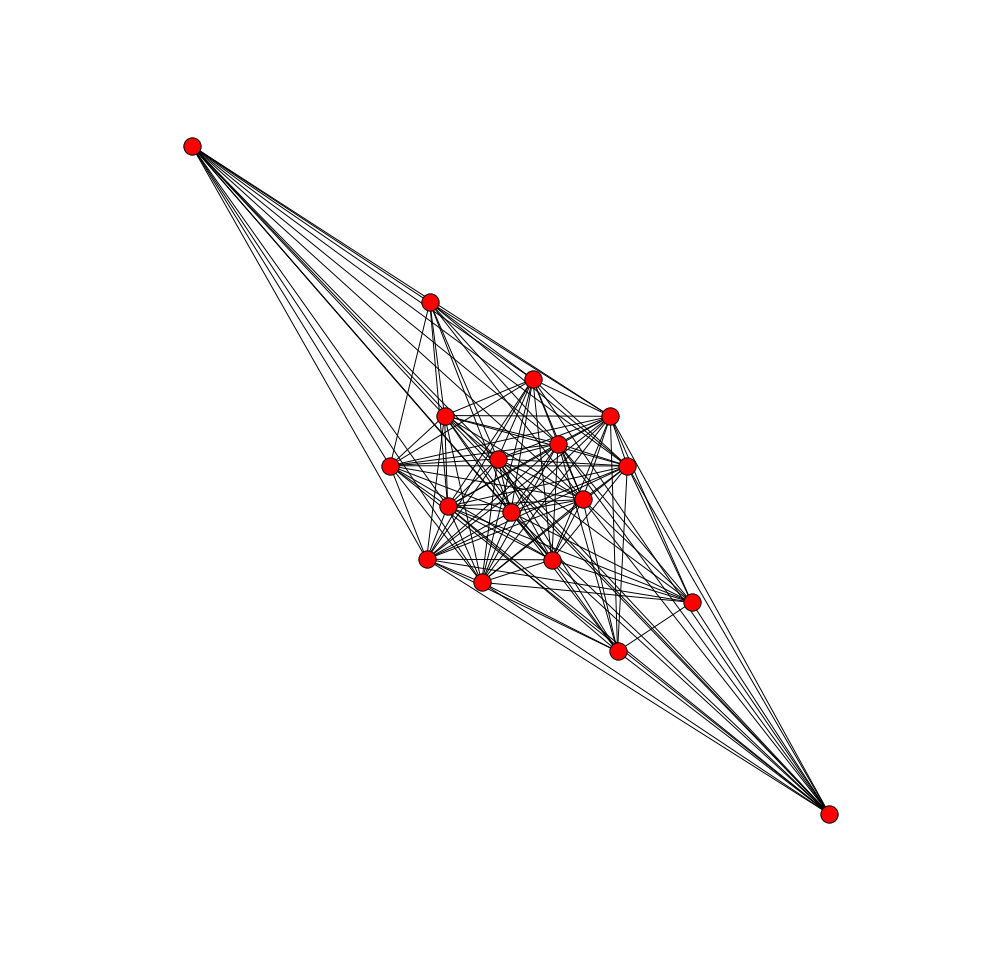

In [8]:
W = bipartite.projected_graph(G, women)
plt.figure(figsize = (13, 13))
nx.draw(W)

In [9]:
sorted(zip(nx.degree_centrality(W).values(), nx.degree_centrality(W).keys()), reverse = True)

[(1.0, 'Verne Sanderson'),
 (1.0, 'Theresa Anderson'),
 (1.0, 'Sylvia Avondale'),
 (1.0, 'Ruth DeSand'),
 (1.0, 'Nora Fayette'),
 (1.0, 'Helen Lloyd'),
 (1.0, 'Evelyn Jefferson'),
 (0.9411764705882353, 'Pearl Oglethorpe'),
 (0.9411764705882353, 'Myra Liddel'),
 (0.9411764705882353, 'Katherina Rogers'),
 (0.9411764705882353, 'Dorothy Murchison'),
 (0.8823529411764706, 'Laura Mandeville'),
 (0.8823529411764706, 'Frances Anderson'),
 (0.8823529411764706, 'Eleanor Nye'),
 (0.8823529411764706, 'Brenda Rogers'),
 (0.7058823529411764, 'Olivia Carleton'),
 (0.7058823529411764, 'Flora Price'),
 (0.6470588235294118, 'Charlotte McDowd')]

**There is an obvious cluster in the center with a few of the women with less centrality than the others. All but three are above 0.88, with those three at 0.7, 0.7, and 0.64.**

**And now the same data for the clubs only.**

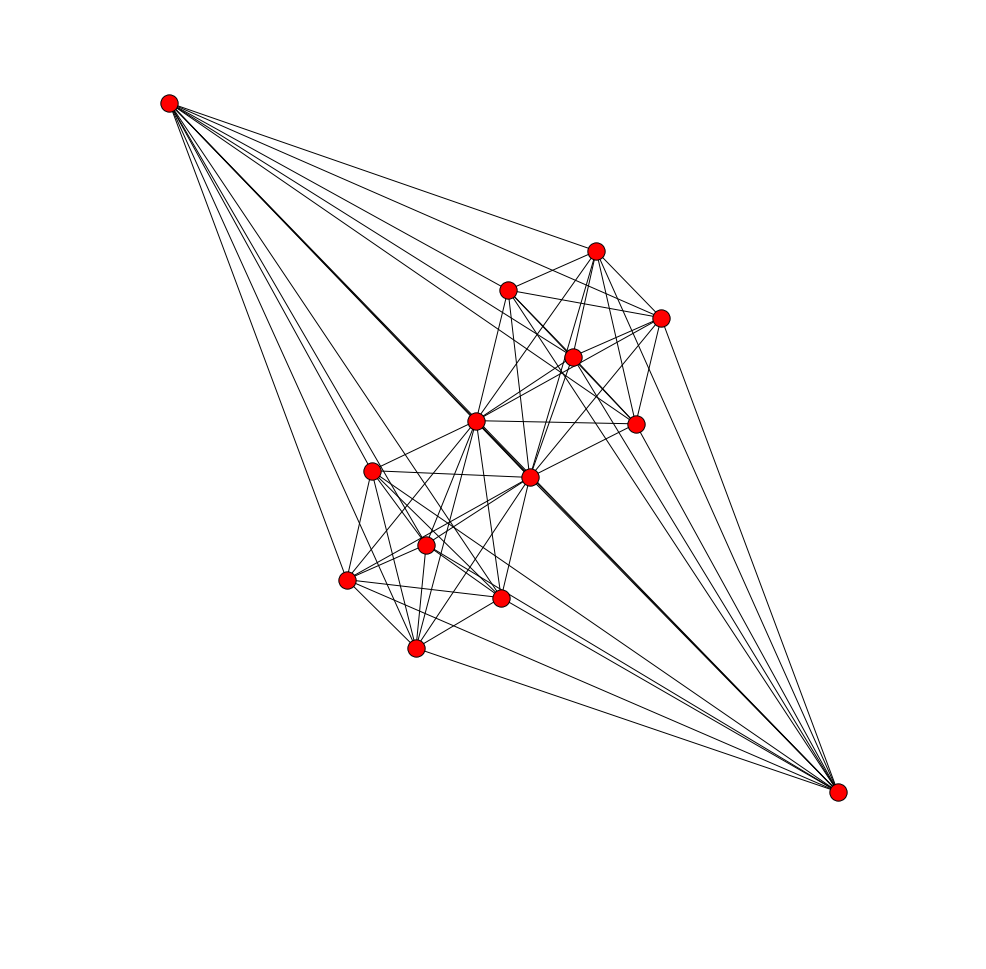

In [10]:
C = bipartite.projected_graph(G, clubs)
plt.figure(figsize = (13, 13))
nx.draw(C)

In [11]:
sorted(zip(nx.degree_centrality(C).values(), nx.degree_centrality(C).keys()), reverse = True)

[(1.0, 'E9'),
 (1.0, 'E8'),
 (1.0, 'E7'),
 (1.0, 'E6'),
 (0.6153846153846154, 'E5'),
 (0.6153846153846154, 'E4'),
 (0.6153846153846154, 'E3'),
 (0.6153846153846154, 'E2'),
 (0.6153846153846154, 'E14'),
 (0.6153846153846154, 'E13'),
 (0.6153846153846154, 'E12'),
 (0.6153846153846154, 'E11'),
 (0.6153846153846154, 'E10'),
 (0.6153846153846154, 'E1')]

**In this case, four of the nodes have a centrality of 1, and the rest are all 0.61. This means there are four central clubs that tend to connect all the others, while the others are only loosely connected to each other.**

**There are many ways to find subgroups, but one of the more straightforward ways from the book is with the following function.**

In [12]:
def create_hc(G, t=1.0):
    """
    Creates hierarchical cluster of graph G from distance matrix
    Maksim Tsvetovat ->> Generalized HC pre- and post-processing to work on labelled graphs and return labelled clusters
    The threshold value is now parameterized; useful range should be determined experimentally with each dataset
    """

    """Modified from code by Drew Conway"""
    
    ## Create a shortest-path distance matrix, while preserving node labels
    labels=G.nodes()    
    path_length=nx.all_pairs_shortest_path_length(G)
    distances=numpy.zeros((len(G),len(G))) 
    i=0   
    for u,p in path_length.items():
        j=0
        for v,d in p.items():
            distances[i][j]=d
            distances[j][i]=d
            if i==j: distances[i][j]=0
            j+=1
        i+=1
    
    # Create hierarchical cluster
    Y=distance.squareform(distances)
    Z=hierarchy.complete(Y)  # Creates HC using farthest point linkage
    # This partition selection is arbitrary, for illustrive purposes
    membership=list(hierarchy.fcluster(Z,t=t))
    # Create collection of lists for blockmodel
    partition=defaultdict(list)
    for n,p in zip(list(range(len(G))),membership):
        partition[p].append(labels[n])
    return list(partition.values())

hc = create_hc(W)
hc

[['Eleanor Nye',
  'Brenda Rogers',
  'Frances Anderson',
  'Evelyn Jefferson',
  'Laura Mandeville',
  'Charlotte McDowd'],
 ['Theresa Anderson',
  'Helen Lloyd',
  'Flora Price',
  'Katherina Rogers',
  'Nora Fayette',
  'Sylvia Avondale',
  'Verne Sanderson',
  'Olivia Carleton',
  'Dorothy Murchison',
  'Ruth DeSand',
  'Myra Liddel',
  'Pearl Oglethorpe']]

** Two subgroups seem to be in the women part of the data. Let's plot the two groups and see where they fall on the main graph. Subgroup 1 will be colored magenta, and subgroup 2 will be colored green. Clubs remains cyan.

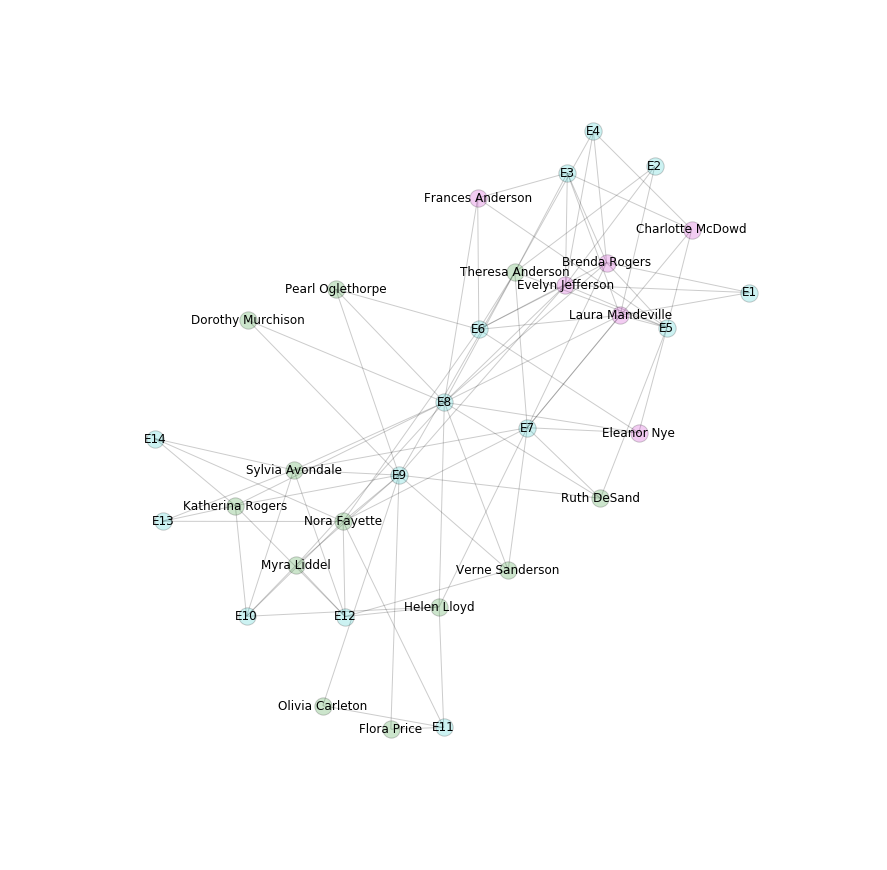

In [13]:
plt.figure(figsize = (15, 15))
plt.axis('off')
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=hc[0], node_color='m', alpha = .2)
nx.draw_networkx_nodes(G, pos, nodelist=hc[1], node_color='g', alpha = .2)
nx.draw_networkx_nodes(G, pos, nodelist=clubs, node_color='c', alpha = .2)
nx.draw_networkx_edges(G, pos, alpha = .2)
nx.draw_networkx_labels(G, pos);

**The groups are much more apparent and reasonable once plotted. There is a small amount of overlap, but the two subgroups mostly remain in their own clusters. A few connecting women and clubs seem to be the bridge between the two groups.**

**The same idea can be used for clubs.**

In [14]:
hc_c = create_hc(C)
hc_c

[['E11', 'E10', 'E13', 'E12', 'E14', 'E9', 'E8', 'E7'],
 ['E5', 'E4', 'E6', 'E1', 'E3', 'E2']]

**Two groups were formed again. Let's see how they looked plotted. The colors remain the same for the women, with subgroup one of clubs being cyan, and subgroup two being red.**

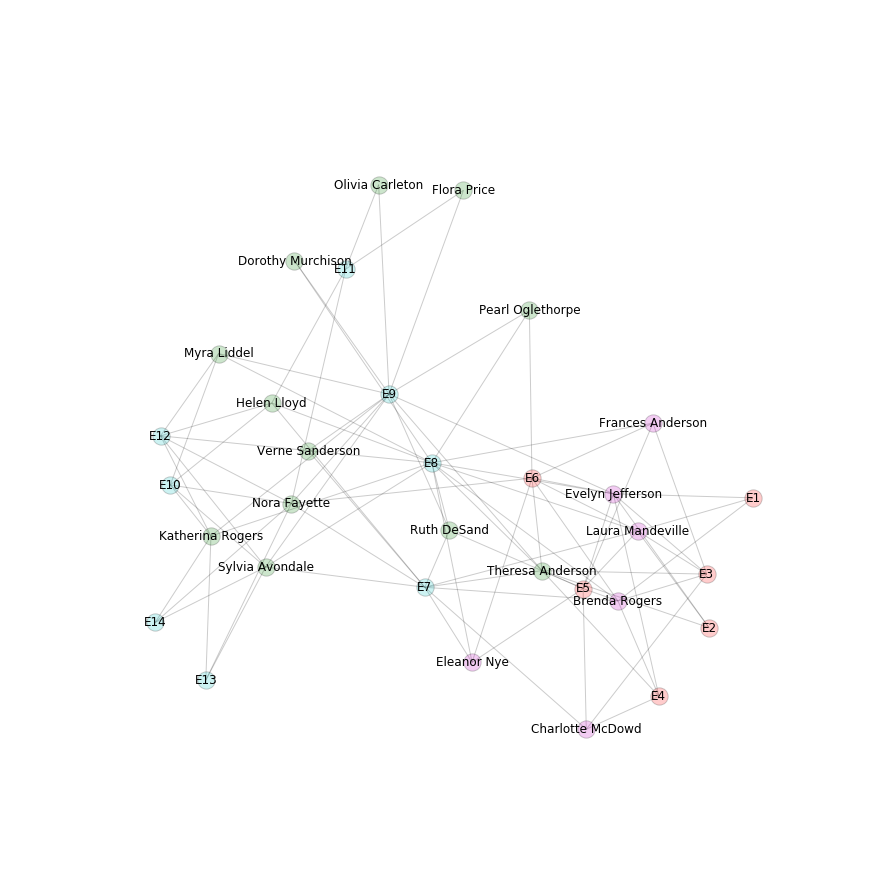

In [15]:
plt.figure(figsize = (15, 15))
plt.axis('off')
pos=nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=hc[0], node_color='m', alpha = .2)
nx.draw_networkx_nodes(G, pos, nodelist=hc[1], node_color='g', alpha = .2)
nx.draw_networkx_nodes(G, pos, nodelist=hc_c[0], node_color='c', alpha = .2)
nx.draw_networkx_nodes(G, pos, nodelist=hc_c[1], node_color='r', alpha = .2)
nx.draw_networkx_edges(G, pos, alpha = .2)
nx.draw_networkx_labels(G, pos);

**A much more telling pattern appears in this case. We can see that subgroup one of women tend to be near subgroup two of clubs, and subgroup two of women tend to be around subgroup one of clubs.**

**There are other methods that can check clusters, but the above method gives a reasonable and expected outcome, so further methods won't be used.**